In [1]:
import json
from sklearn.metrics import roc_auc_score

In [11]:
# List out all experiments

linear_experiments = [
    "exp_1_numeric_lr",
    "exp_1_tfidf_lr",
    "exp_1_combined_lr",
    "exp_1_combined_svm",
    "exp_1_combined_linear_svc_optuna"
]
tree_experiments = [
    "exp_2_random_forest_numeric",
    "exp_2_random_forest_all",
    "exp_2_xgboost_all",
    "exp_2_lgbm_all",
    "exp_2_catboost_all",
    "exp_2_catboost_optuna"
]

nn_experiments = [
    "exp_3_mlp_baseline",
    "exp_3_charcnn",
    "exp_3_bilstm",
    "exp_3_hybrid"
]

transformer_experiments = [
    # "exp_4_deberta_url_only",
    # "exp_4_deberta_url_features"
]

In [12]:
# Get metrics json file from each experiment
linear_results = {}
tree_results = {}
nn_results = {}
transformer_results = {}

for exp in linear_experiments:
    with open(f"experiments/{exp}/metrics.json", "r") as f:
        linear_results[exp] = json.load(f)
for exp in tree_experiments:
    with open(f"experiments/{exp}/metrics.json", "r") as f:
        tree_results[exp] = json.load(f)
for exp in nn_experiments:
    with open(f"experiments/{exp}/metrics.json", "r") as f:
        nn_results[exp] = json.load(f)
for exp in transformer_experiments:
    with open(f"experiments/{exp}/metrics.json", "r") as f:
        transformer_results[exp] = json.load(f)

In [16]:
# Get prediction csv file from each experiment
linear_predictions = {}
tree_predictions = {}
nn_predictions = {}
transformer_predictions = {}

for exp in linear_experiments:
    with open(f"experiments/{exp}/{exp}_prediction.csv", "r") as f:
        linear_predictions[exp] = f.read()
for exp in tree_experiments:
    with open(f"experiments/{exp}/{exp}_prediction.csv", "r") as f:
        tree_predictions[exp] = f.read()
for exp in nn_experiments:
    with open(f"experiments/{exp}/{exp}_prediction.csv", "r") as f:
        nn_predictions[exp] = f.read()
for exp in transformer_experiments:
    with open(f"experiments/{exp}/{exp}_prediction.csv", "r") as f:
        transformer_predictions[exp] = f.read()

In [19]:
# Eval script to score experiments by roc-auc on test set
def evaluate_experiments(results_dict, predictions_dict):
    """
    Evaluate experiment predictions using ROC AUC.

    This function gracefully handles two prediction CSV formats:
    1. id, probability
    2. id, target, probability

    When only probabilities are provided it will try to read ground
    truth labels from dataset/df_test_feature_engineered.csv (preferred)
    and fall back to dataset/test.csv if the former doesn't exist.
    """
    import pandas as pd
    from io import StringIO
    from pathlib import Path

    eval_results = {}

    test_candidates = [Path("dataset/df_test_feature_engineered.csv"), Path("dataset/test.csv")]

    for exp in results_dict.keys():
        csv_text = predictions_dict.get(exp, "")
        if not csv_text:
            # No predictions for this experiment
            continue

        # Parse predictions using pandas for robust CSV handling
        try:
            preds_df = pd.read_csv(StringIO(csv_text))
        except Exception as e:
            raise RuntimeError(f"Could not parse prediction CSV for {exp}: {e}")

        # Extract true labels
        if "target" in preds_df.columns:
            y_true = preds_df["target"].astype(int).tolist()
        elif "label" in preds_df.columns:
            y_true = preds_df["label"].astype(int).tolist()
        else:
            # Try to align with test dataset
            y_true = None
            for cand in test_candidates:
                if cand.exists():
                    test_df = pd.read_csv(cand)
                    # If 'id' exists in predictions, attempt indexed alignment
                    if "id" in preds_df.columns and "target" in test_df.columns:
                        try:
                            y_true = test_df["target"].iloc[preds_df["id"].astype(int).tolist()].astype(int).tolist()
                        except Exception:
                            # Fallback: if pred length <= test rows, use first N rows
                            if len(test_df) >= len(preds_df):
                                y_true = test_df["target"].iloc[: len(preds_df)].astype(int).tolist()
                            else:
                                raise RuntimeError(f"Could not align test labels for {exp} using {cand}")
                    break

        if y_true is None:
            raise RuntimeError(
                f"Could not find ground-truth labels for {exp}. "
                "Ensure your prediction CSV includes a target/label column or dataset/test.csv exists."
            )

        # Extract probabilities / scores
        if "probability" in preds_df.columns:
            y_scores = preds_df["probability"].astype(float).tolist()
        elif "proba" in preds_df.columns:
            y_scores = preds_df["proba"].astype(float).tolist()
        elif preds_df.shape[1] >= 2:
            # Try last column as fallback
            y_scores = preds_df.iloc[:, -1].astype(float).tolist()
        else:
            raise RuntimeError(f"Could not locate probability column for {exp} in prediction CSV")

        roc_auc = roc_auc_score(y_true, y_scores)
        eval_results[exp] = {
            "roc_auc": roc_auc,
            "original_metrics": results_dict[exp]
        }

    return eval_results

In [20]:
# Evaluate all experiments
linear_eval = evaluate_experiments(linear_results, linear_predictions)
tree_eval = evaluate_experiments(tree_results, tree_predictions)
nn_eval = evaluate_experiments(nn_results, nn_predictions)
transformer_eval = evaluate_experiments(transformer_results, transformer_predictions)

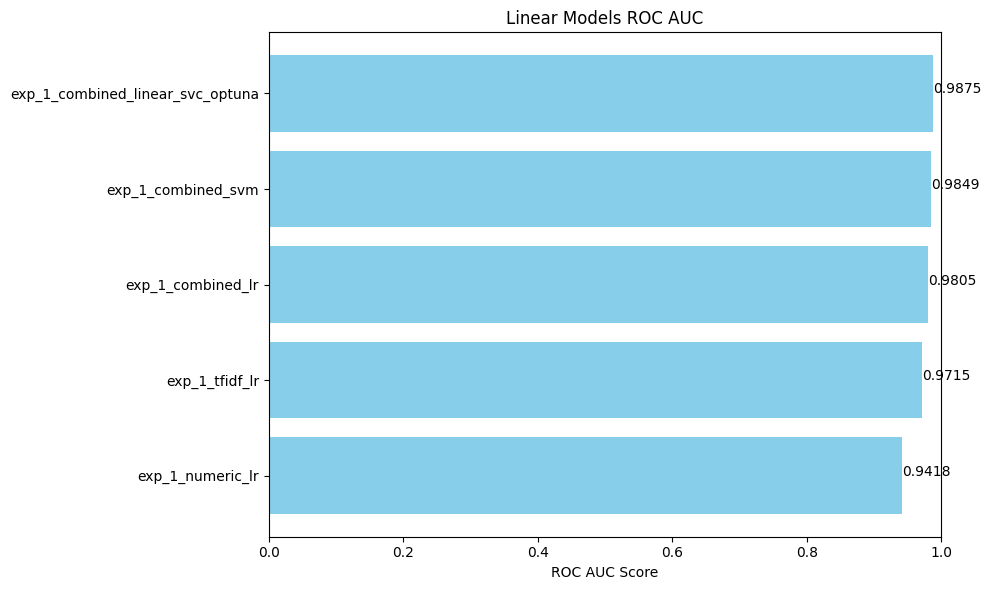

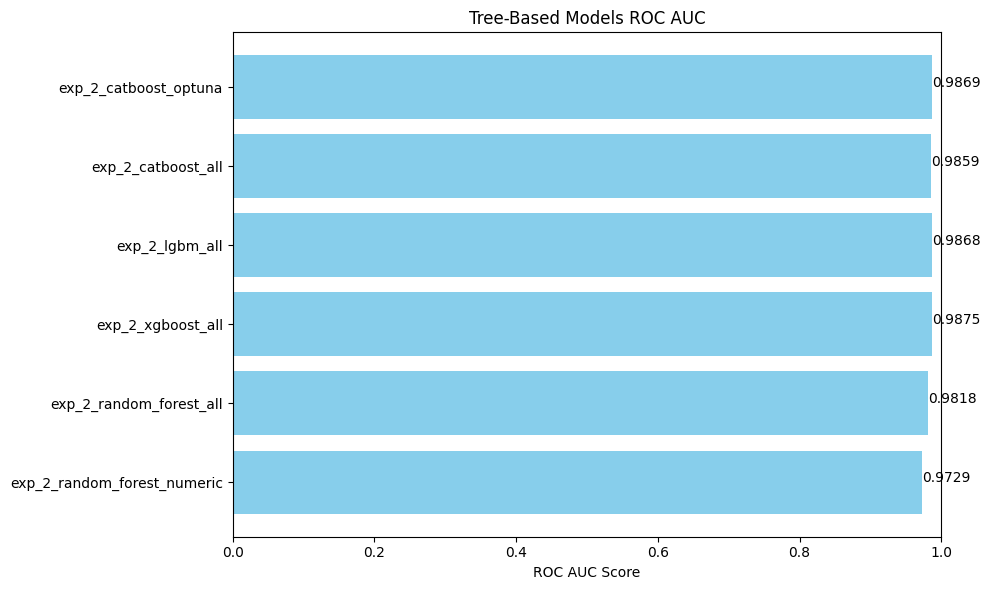

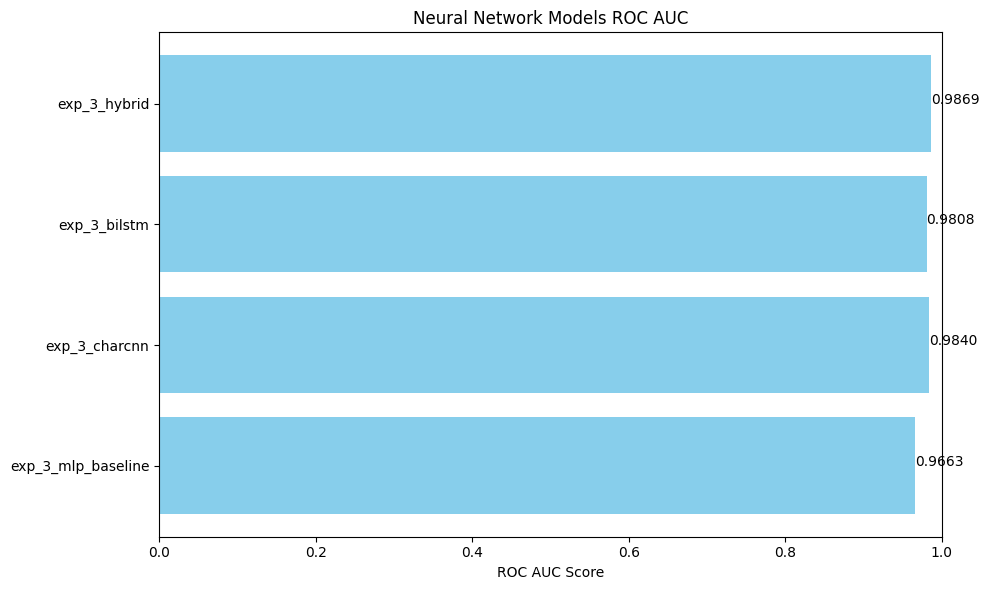

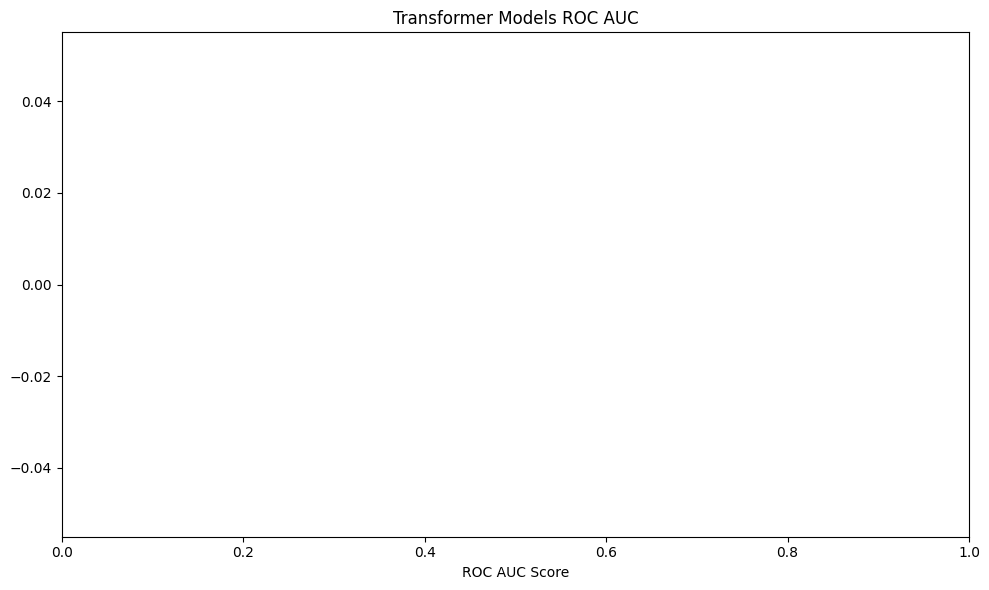

In [21]:
# Plot ROC-AUC scores
import matplotlib.pyplot as plt

def plot_roc_auc(eval_dict, title):
    experiments = list(eval_dict.keys())
    roc_aucs = [eval_dict[exp]["roc_auc"] for exp in experiments]

    plt.figure(figsize=(10, 6))
    plt.barh(experiments, roc_aucs, color='skyblue')
    plt.xlabel('ROC AUC Score')
    plt.title(title)
    plt.xlim(0, 1)
    for index, value in enumerate(roc_aucs):
        plt.text(value, index, f"{value:.4f}")
    plt.tight_layout()
    plt.show()

plot_roc_auc(linear_eval, "Linear Models ROC AUC")
plot_roc_auc(tree_eval, "Tree-Based Models ROC AUC")
plot_roc_auc(nn_eval, "Neural Network Models ROC AUC")
plot_roc_auc(transformer_eval, "Transformer Models ROC AUC")
